In [1]:
from SERDatasets.kde_probability import kde_probability_bs, get_random_observations_fast
from kde_diffusion import kde2d
import torch

/z/tavernor/code/ModelingIndividualEvaluators/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create one example with 5 annotators in [-1,1]
# Create random observations by annotator, we assume annotators could label 1-5 and this has been scaled to  
act = torch.randint(1,6,(1,5))
val = torch.randint(1,6,(1,5))
act = torch.as_tensor([[4,4,4,3,3]])
val = torch.as_tensor([[4,3,5,4,3]])
# Now scale this into range [-1,1]
a,b = -1,1
minx, maxx = 1, 5
print(act,val)
act = a + (act-minx)*(b-a)/(maxx-minx)
val = a + (val-minx)*(b-a)/(maxx-minx)
act, val

tensor([[4, 4, 4, 3, 3]]) tensor([[4, 3, 5, 4, 3]])


(tensor([[0.5000, 0.5000, 0.5000, 0.0000, 0.0000]]),
 tensor([[0.5000, 0.0000, 1.0000, 0.5000, 0.0000]]))

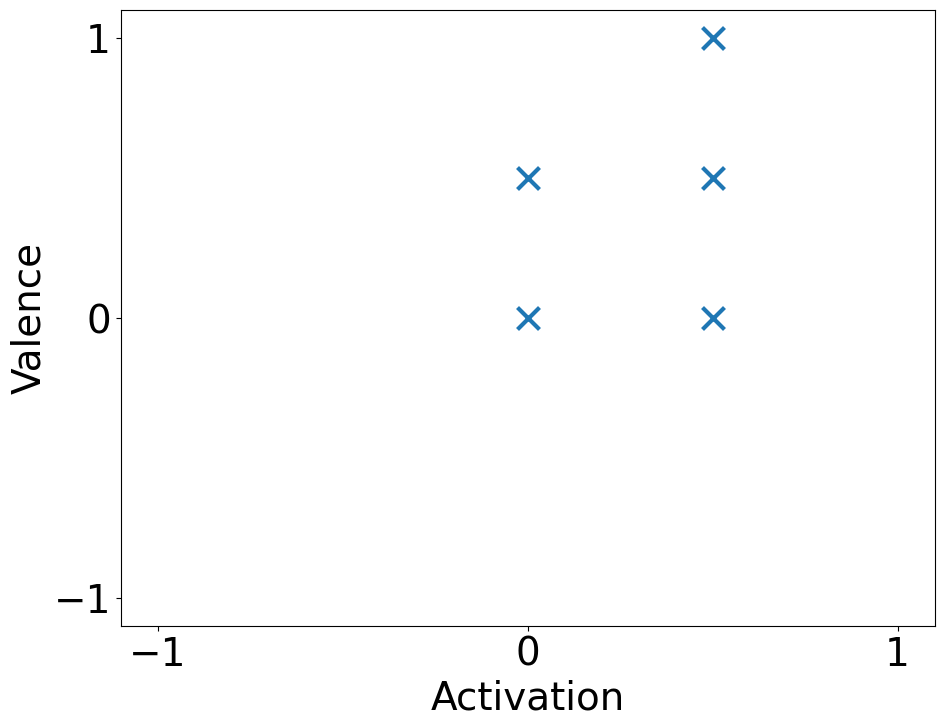

In [67]:
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 28}
matplotlib.rc('font', **font)

plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
pth = plt.scatter(act, val, s=250, marker='x', linewidths=3)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
# pth.axes.spines['top'].set_visible(False)
# pth.axes.spines['left'].set_visible(False)
# pth.axes.spines['right'].set_visible(False)
# pth.axes.spines['bottom'].set_visible(False)
plt.xlabel('Activation')
plt.ylabel('Valence')
plt.gcf().set_size_inches(10.5,8)
plt.savefig('./figures/base_scatter_plot.png', bbox_inches='tight')

In [81]:
ract, rval = get_random_observations_fast(act, val)

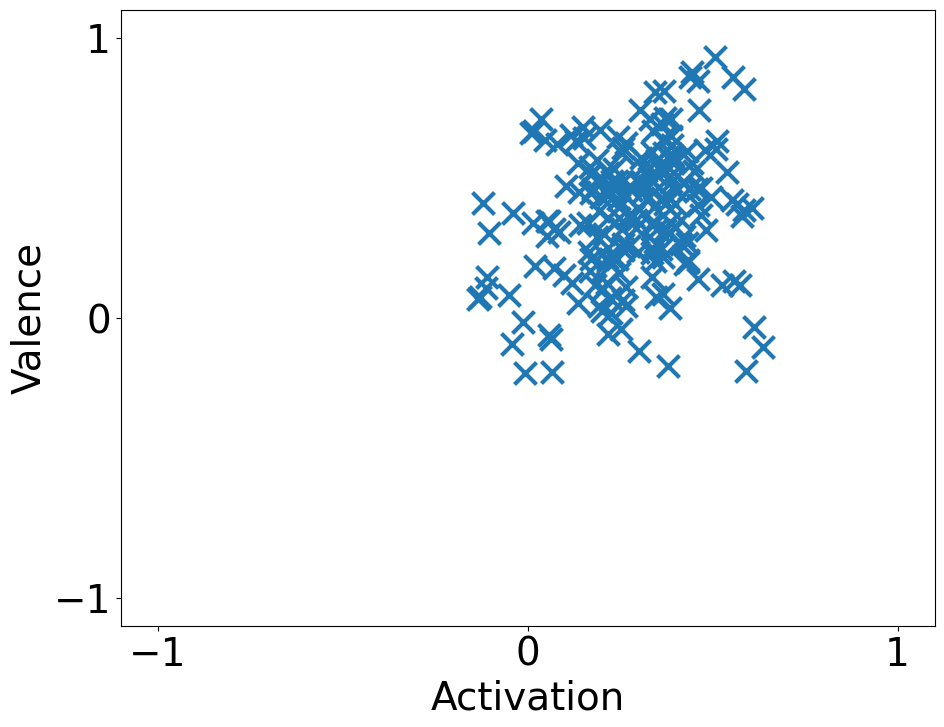

In [86]:
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
pth = plt.scatter(ract, rval, s=250, marker='x', linewidths=3)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.xlabel('Activation')
plt.ylabel('Valence')
plt.gcf().set_size_inches(10.5,8)
plt.savefig('./figures/sampled_scatter.png', bbox_inches='tight')

In [87]:
baseline_dist = kde2d(ract.squeeze().numpy(), rval.squeeze().numpy(), n=256, limits=((-1,1),(-1,1)))

In [88]:
import numpy as np
# Now convert this into a 4x4 distribution
prob_grid_size = 4
density = torch.from_numpy(baseline_dist[0].T.copy()) # Transpose to make plot match above plots, otherwise output has valence on x axis 
size = density.shape[1]
xbins = torch.linspace(0,size,prob_grid_size+1, dtype=torch.int)
ybins = torch.linspace(0,size,prob_grid_size+1, dtype=torch.int)
probability_distributions = torch.zeros(4,4)
# Want to iterate between each pair of bins to find mean values
for x in range(1,prob_grid_size+1):
    for y in range(1,prob_grid_size+1):
        densities_in_range = density[xbins[x-1]:xbins[x], ybins[y-1]:ybins[y]]
        mean = densities_in_range.mean()
        probability_distributions[x-1,y-1] = mean
# Now normalize the distribution to sum to 1
probability_distributions = probability_distributions/(probability_distributions.sum())

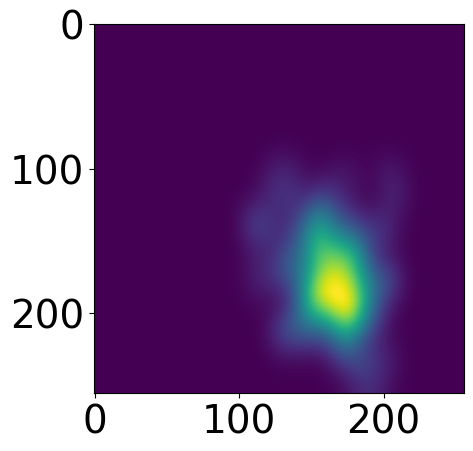

In [89]:
import numpy as np
plt.imshow(density)

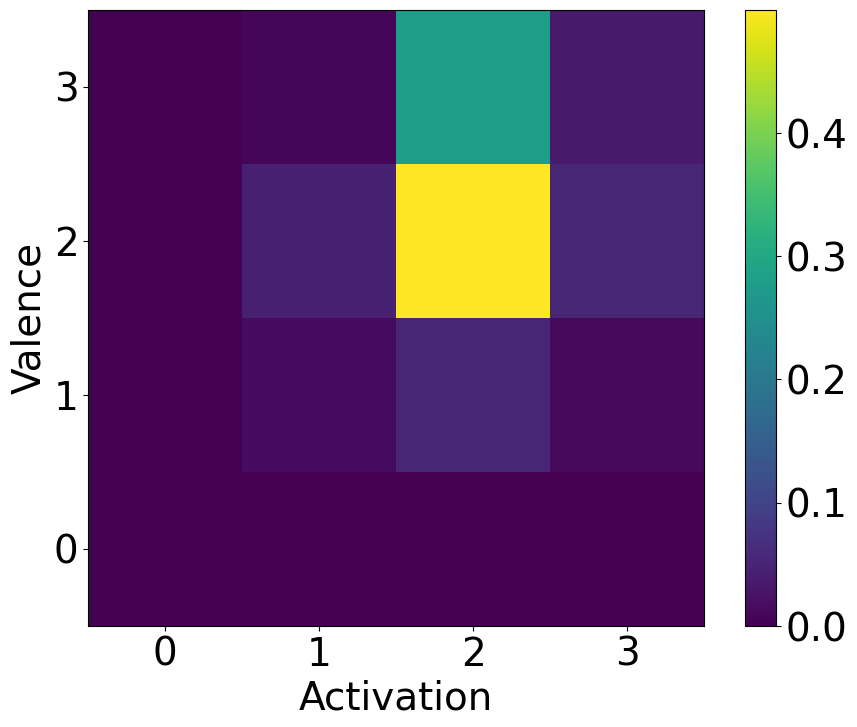

In [90]:
import matplotlib
m = probability_distributions.max()
colors = matplotlib.colormaps['viridis']
pos = plt.imshow(probability_distributions.numpy(), vmin=0, vmax=m, cmap=colors)
plt.colorbar(pos)
plt.xticks([0, 1, 2, 3])
plt.yticks([3, 2, 1, 0])
plt.xlabel('Activation')
plt.ylabel('Valence')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10.5,8)
plt.savefig('./figures/KDE_4x4_output.png', bbox_inches='tight')

In [91]:
# Now show this for differentiable kde 
kde_dist = kde_probability_bs(ract.cuda(), rval.cuda(), prob_grid_size=4, skip_observations=True, temperature=8).squeeze().t()
# Normalize density
kde_dist = kde_dist/kde_dist.sum()

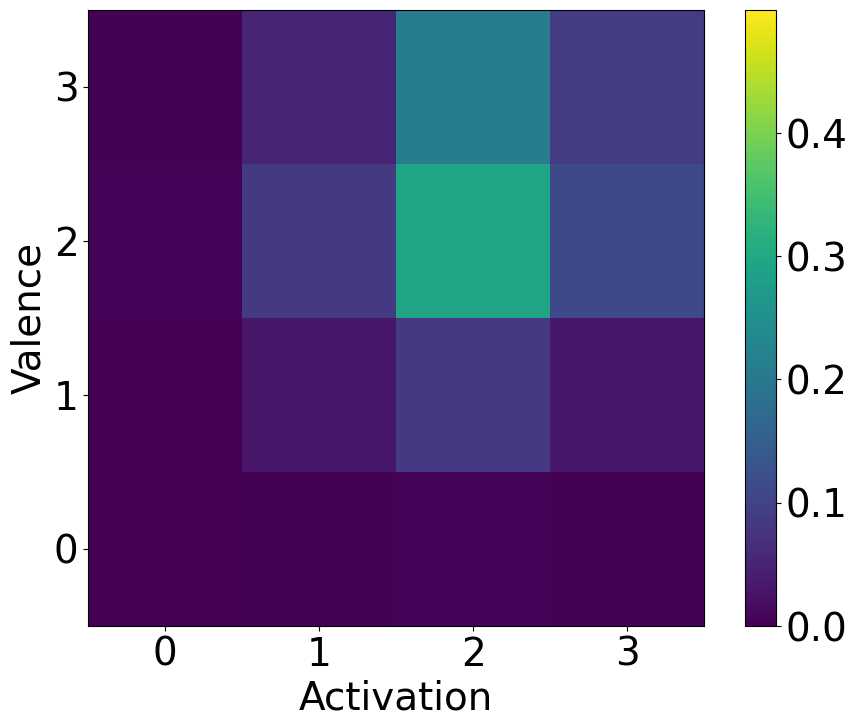

In [92]:
colors = matplotlib.colormaps['viridis']
pos = plt.imshow(kde_dist.cpu().numpy(), vmin=0, vmax=m, cmap=colors)
plt.colorbar(pos)
plt.xticks([0, 1, 2, 3])
plt.yticks([3, 2, 1, 0])
plt.xlabel('Activation')
plt.ylabel('Valence')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10.5,8)
plt.savefig('./figures/DiffKDE_4x4_output.png', bbox_inches='tight')

tensor(0.5000) tensor(0.5000) 2 2
tensor(0.5000) tensor(0.) 2 1
tensor(0.5000) tensor(1.) 2 3
tensor(0.) tensor(0.5000) 1 2
tensor(0.) tensor(0.) 1 1


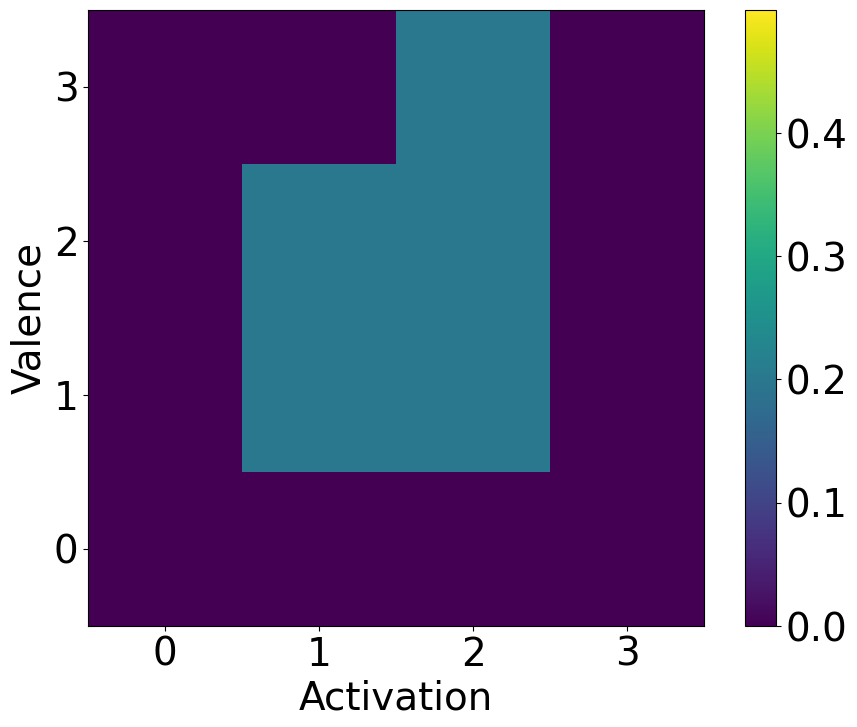

In [100]:
# Now we want to show why the sampling of 200 is necessary
# First convert the original act/val samples to a distribution 
# Since votes are based on evaluations in range -1,1 boundaries are drawn at [-1,-0.5), [-0.5, 0), [0, 0.5), [0.5, 1]
bounds = torch.linspace(-1,1,5)
upper_bounds = bounds[1:]
lower_bounds = bounds[:-1]
votes = torch.zeros((4,4))
for annotator in range(act.shape[1]):
    act_vote = act[0,annotator]
    val_vote = val[0,annotator]
    l_comparitor = lambda x, y: x < y if x > -1 else x <= y
    r_comparitor = lambda x, y: x <= y
    act_vote_i, val_vote_i = None, None
    for i in range(len(upper_bounds)):
        lower = lower_bounds[i]
        upper = upper_bounds[i]
        if l_comparitor(lower, act_vote) and r_comparitor(act_vote, upper):
            act_vote_i = i
        if l_comparitor(lower, val_vote) and r_comparitor(val_vote, upper):
            val_vote_i = i
    votes[act_vote_i,val_vote_i] += 1
    print(act_vote, val_vote, act_vote_i, val_vote_i)

# In this case we consider rating of 2 as low-medium and rating 4 as high 
votes = votes/5
fig, axs = plt.subplots(1,1)
pos = axs.imshow(votes.numpy().T, vmin=0, vmax=m, cmap=colors)
plt.colorbar(pos)
plt.xticks([0, 1, 2, 3])
plt.yticks([3, 2, 1, 0])
plt.xlabel('Activation')
plt.ylabel('Valence')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10.5,8)
plt.savefig('./figures/basic_4x4_less_than.png', bbox_inches='tight')

In [101]:
act, val

(tensor([[0.5000, 0.5000, 0.5000, 0.0000, 0.0000]]),
 tensor([[0.5000, 0.0000, 1.0000, 0.5000, 0.0000]]))

tensor(0.5000) tensor(0.5000) 3 3
tensor(0.5000) tensor(0.) 3 2
tensor(0.5000) tensor(1.) 3 3
tensor(0.) tensor(0.5000) 2 3
tensor(0.) tensor(0.) 2 2


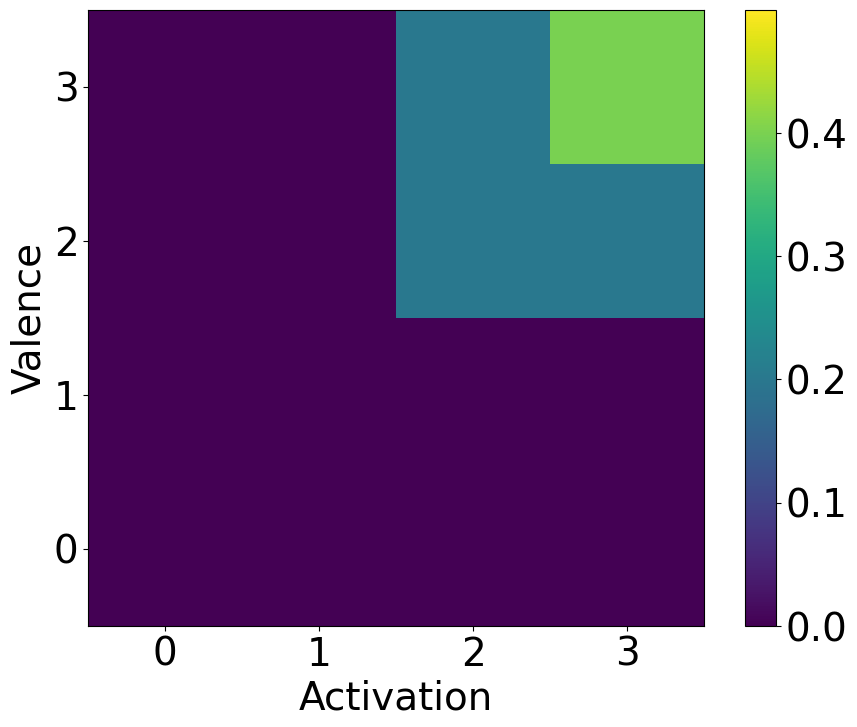

In [102]:
# Now we want to show why the sampling of 200 is necessary
# First convert the original act/val samples to a distribution 
# Since votes are based on evaluations in range -1,1 boundaries are drawn at [-1,-0.5), [-0.5, 0), [0, 0.5), [0.5, 1]
bounds = torch.linspace(-1,1,5)
upper_bounds = bounds[1:]
lower_bounds = bounds[:-1]
votes = torch.zeros((4,4))
for annotator in range(act.shape[1]):
    act_vote = act[0,annotator]
    val_vote = val[0,annotator]
    l_comparitor = lambda x, y: x <= y
    r_comparitor = lambda x, y: x < y if y < 1 else x <= y
    act_vote_i, val_vote_i = None, None
    for i in range(len(upper_bounds)):
        lower = lower_bounds[i]
        upper = upper_bounds[i]
        if l_comparitor(lower, act_vote) and r_comparitor(act_vote, upper):
            act_vote_i = i
        if l_comparitor(lower, val_vote) and r_comparitor(val_vote, upper):
            val_vote_i = i
    votes[act_vote_i,val_vote_i] += 1
    print(act_vote, val_vote, act_vote_i, val_vote_i)
# In this case we consider rating of 2 as low-medium and rating 4 as high 
votes = votes/5
fig, axs = plt.subplots(1,1)
pos = axs.imshow(votes.numpy().T, vmin=0, vmax=m, cmap=colors)
plt.colorbar(pos)
plt.xticks([0, 1, 2, 3])
plt.yticks([3, 2, 1, 0])
plt.xlabel('Activation')
plt.ylabel('Valence')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10.5,8)
plt.savefig('./figures/basic_4x4_less_than_on_right.png', bbox_inches='tight')